In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import math
import urllib
import os
import os.path as osp
import nbformat
import json
import ssl
import sys
import time
import hashlib
import pickle
import io
import random
import getpass
import inspect
import socket
import tempfile
from datetime import datetime, date
from datetime import timedelta

import matplotlib
import pylab # for side effects on matplotlib
import pandas as pd
import numpy as np
import IPython.display as ipd

In [34]:
#functions
def array_to_html(arr, row_names=None, col_names=None, title=None):
    ''' array_to_html, if placed at the end of a Anaconda cell, will
        display the array in html.   It uses pandas.
    '''
    if len(arr.shape) not in [1, 2]:
        print('The array must be a one- or two-dimensional array. This array is',
             len(arr.shape), 'dimensions')
        return

    if title:
        ipd.display(ipd.HTML('<h1>' + title + '</h1>'))
    df = pd.DataFrame(arr, index=row_names, columns=col_names)
    return ipd.display(ipd.HTML(df.to_html()))
def separate(string):
    separated=[]
    semic=[-1]
    reverse=string[::-1]
    lastword=string[-reverse.find(';'):-1]
    for posi in range(len(string)):
        if string[posi]==';':
            semic.append(posi)
    for positionx in range(len(semic)-1):
        word=string[semic[positionx]+1:semic[positionx+1]]
        separated.append(float(word))
    separated.append(float(lastword))
    return separated
def notuntillfloat(name):
    a = input(name)
    try:
        b= float(a)
    except ValueError:
        print('Please enter a float')
        a= float(notuntillfloat(name))
    return a
#notuntillfloat('Please enter the Target OD 600 ')
def notuntillint(name):
    a = input(name)
    try:
        b= int(a)
    except ValueError:
        print('Please enter an integer')
        a= int(notuntillint(name))
    return a
#notuntillint('Please enter the total number of samples you have ')
def notuntillindex(name,array):
    a = int(notuntillint(name))
    try:
        b= array[a-1]
    except IndexError:
        print('The index you entered is out of bound. Please enter the currect position')
        a= int(notuntillindex(name,array))
    return a
#notuntillindex('Please enter the number of samples you want to change ',[1,2,3,4,5])

#defince names
alphabet='ABCDEFGHIJKLMNOPQRSTUVWXYZ'
nameforcol=[]
for item in alphabet:
    nameforcol.append(item)
#program info
print('Plate Reader Result Analyst---V2.0.3 Created by Harry Wang')
print('Please make adjustments based on real conditions')
print('Warning: This program is not designed for beginners')

Plate Reader Result Analyst---V2.0.3 Created by Harry Wang
Please make adjustments based on real conditions


In [3]:
#OD 600 reader
def ODreader(filename):
    #read file
    file_OD=filename
    x=pd.read_csv(file_OD,header=None,names=nameforcol)
    #information(not necessary for the program)
    
    #print('Information: '+ x['A'][13])
    #print('The protocol used is: '+x['B'][1])
    
    #select needrow
    needrow=x[3:11]
    plateod=needrow.copy()
    platereading=[]
    for i in range(3,11):
        row=[]
        for j in range(2,14):
            row.append(plateod[nameforcol[j]][i])
        platereading.append(row)
    ODresult=[]
    #convert to 2D array of float
    for i2 in range(len(platereading)):
        row2=[]
        for j2 in range(len(platereading[0])):
            local=float(platereading[i2][j2])
            row2.append(local)
        ODresult.append(row2)
    ODresult=np.array(ODresult)
    #return a numpy array
    return ODresult


#test case
ODresult1=ODreader('OD_sample.csv')
array_to_html(ODresult1, row_names=nameforcol[:8], col_names=range(1,13), title='The OD reading')

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.1521,0.1570,0.0671,0.1471,0.1468,0.1250,0.1258,0.1310,0.1317,0.0749,0.0659,0.0648
B,0.1527,0.1545,0.0994,0.1559,0.1505,0.1338,0.1292,0.1335,0.1319,0.0747,0.0658,0.0661
C,0.1455,0.1444,0.0688,0.1376,0.1373,0.1253,0.1212,0.1246,0.1214,0.0691,0.0660,0.0647
D,0.1439,0.1437,0.0697,0.1345,0.1373,0.1142,0.1182,0.1271,0.1221,0.0636,0.0655,0.0651
E,0.1437,0.1398,0.0770,0.1312,0.1349,0.1225,0.1164,0.1275,0.1260,0.0623,0.0639,0.0646
F,0.1452,0.1439,0.0641,0.1379,0.1409,0.1209,0.1203,0.1256,0.1268,0.0636,0.0643,0.0660
G,0.1440,0.1428,0.1452,0.1361,0.1386,0.1202,0.1219,0.1252,0.1244,0.0635,0.0633,0.0672
H,0.1578,0.1420,0.0639,0.1430,0.1437,0.1251,0.1228,0.1259,0.1239,0.0611,0.0631,0.0660


In [4]:
# read file
file_Time='time_data_sample.csv'
x=pd.read_csv(file_Time,header=None,names=nameforcol)
x.head()

,A,B,C,D,E,F,G,H,I,J,...,Q,R,S,T,U,V,W,X,Y,Z
0,##BLOCKS= 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Plate:,Plate1,1.3,PlateFormat,Kinetic,Fluorescence,TRUE,Raw,FALSE,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Temperature(¡C),1.0,2,3,4,5,6,7,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00:00:00,30,6950.0,7351,41892,40615,44822,42838,49119,48154.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,6461.0,7417,44843,42822,40186,42001,48424,48767.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
def TimeArrayReader(filename):
    file_Time=filename
        #read file
    x=pd.read_csv(file_Time,header=None,names=nameforcol)
    timepoints=len(x)//9 -1
    #find first line
    for place in range(len(x)):
        if x['A'][place]=='00:00:00':
            break
    #find start point
    start=0
    end=26
    for d in range(26):
        val=x[nameforcol[d]][place+1]
        if str(val)!='nan':
            start=d
            break
    for e in range(start,26):
        val2=x[nameforcol[e]][place+1]
        if str(val2)=='nan':
            end=e
            break
    distance=e-d
    #create dictionary for rows
    timediff={}
    for num in range(timepoints):
        name='TimePoint'+str(num)
        timediff[name]=x[place+num*9:place+8+num*9]

    #create dictionary for needed columns    
    timepointreading={}
    listofkeys=list(timediff.keys())
    for pla in range(len(listofkeys)):
        timesr=[]
        a=[]
        plat=timediff[listofkeys[pla]]
        #create array from datafram
        for i in range(place+pla*9,place+8+pla*9):
            row=[]
            for j in range(start,end):
                row.append(plat[nameforcol[j]][i])
            a.append(row)
        #convert everything to float
        for i2 in range(len(a)):
            row2=[]
            for j2 in range(len(a[1])):
                local=float(a[i2][j2])
                row2.append(local)
            timesr.append(row2)  
        timepointreading[listofkeys[pla]]=np.array(timesr)
    #return dictionary with keys of TimePointX, each contains a numpy array
    return timepointreading
#test
dictionaryresult=TimeArrayReader('time_data_sample.csv')
#data visualization (should be modifided based on file)
tempkey=list(dictionaryresult.keys())
for ke in tempkey:
    plateread=dictionaryresult[ke]
    array_to_html(plateread, row_names=nameforcol[:8], col_names=range(1,13), title=ke+' Plate Reading')

,1,2,3,4,5,6,7,8,9,10,11,12
A,6950.0,7351.0,41892.0,40615.0,44822.0,42838.0,49119.0,48154.0,49610.0,49199.0,44060.0,44624.0
B,6461.0,7417.0,44843.0,42822.0,40186.0,42001.0,48424.0,48767.0,48322.0,48435.0,45630.0,47101.0
C,6577.0,7641.0,45617.0,42233.0,44640.0,43236.0,48672.0,49620.0,52367.0,48440.0,44503.0,48258.0
D,6448.0,7794.0,46147.0,43806.0,40944.0,44427.0,50274.0,53016.0,49548.0,50896.0,44453.0,46574.0
E,5776.0,7121.0,44012.0,40748.0,44159.0,42089.0,49992.0,52059.0,46393.0,49302.0,45715.0,42920.0
F,6887.0,7336.0,45299.0,41325.0,43071.0,42348.0,53384.0,49522.0,49522.0,49135.0,46842.0,49416.0
G,7169.0,6831.0,44120.0,41257.0,42259.0,41700.0,46903.0,53341.0,45892.0,49807.0,45999.0,45945.0
H,7215.0,7216.0,41728.0,37423.0,41465.0,42642.0,51926.0,48451.0,44430.0,48076.0,48353.0,41633.0


,1,2,3,4,5,6,7,8,9,10,11,12
A,6139.0,5499.0,44741.0,39850.0,41742.0,39497.0,49900.0,50229.0,46921.0,45579.0,43048.0,45463.0
B,5877.0,6268.0,44108.0,42603.0,38070.0,41645.0,53693.0,51172.0,48817.0,44226.0,42606.0,45632.0
C,5879.0,6996.0,44447.0,41974.0,41131.0,42593.0,51996.0,52159.0,51765.0,49305.0,45834.0,50599.0
D,6324.0,7498.0,45499.0,42706.0,40135.0,41306.0,53566.0,54405.0,48078.0,48801.0,46290.0,43988.0
E,6886.0,7274.0,49978.0,44375.0,43028.0,44933.0,56405.0,58641.0,59978.0,58246.0,57021.0,48122.0
F,6154.0,6547.0,53994.0,52045.0,51038.0,52093.0,71235.0,75936.0,75161.0,78289.0,60440.0,66370.0
G,7556.0,6770.0,56456.0,54721.0,53998.0,51253.0,82365.0,79009.0,81917.0,81080.0,69162.0,74651.0
H,7051.0,6435.0,53161.0,49352.0,54395.0,54995.0,80345.0,80639.0,83444.0,85221.0,69609.0,52992.0


,1,2,3,4,5,6,7,8,9,10,11,12
A,6434.0,6300.0,39348.0,41691.0,43527.0,42683.0,53794.0,53954.0,57496.0,55404.0,50745.0,48893.0
B,5667.0,6621.0,46083.0,42771.0,42764.0,42930.0,54952.0,57883.0,53329.0,56416.0,51193.0,52938.0
C,6120.0,6789.0,44666.0,44835.0,43267.0,45336.0,59867.0,56170.0,62289.0,60318.0,51048.0,53186.0
D,5666.0,6284.0,47975.0,45012.0,40622.0,43149.0,58301.0,60095.0,56782.0,59421.0,52417.0,54941.0
E,6340.0,7125.0,50382.0,50937.0,50829.0,47967.0,70972.0,72596.0,76695.0,77704.0,67435.0,67549.0
F,7236.0,7574.0,70404.0,69227.0,74461.0,70465.0,104527.0,105013.0,116534.0,120928.0,90460.0,96558.0
G,5498.0,6058.0,86451.0,83023.0,86111.0,91279.0,150324.0,153569.0,167253.0,176674.0,131541.0,140152.0
H,6395.0,6450.0,95818.0,85944.0,96949.0,98614.0,167518.0,191094.0,209314.0,207003.0,153327.0,61368.0


,1,2,3,4,5,6,7,8,9,10,11,12
A,6495.0,7095.0,43851.0,41631.0,44036.0,44027.0,57700.0,59650.0,64910.0,62126.0,55928.0,60429.0
B,6013.0,7194.0,44963.0,47207.0,42212.0,44848.0,60983.0,62675.0,61558.0,64087.0,54352.0,57508.0
C,7028.0,6462.0,46753.0,45746.0,48096.0,49227.0,65571.0,64567.0,72882.0,70672.0,59105.0,61813.0
D,6180.0,7697.0,48938.0,47035.0,43831.0,51984.0,73052.0,63545.0,63110.0,65126.0,61468.0,63106.0
E,7134.0,7190.0,63835.0,51066.0,53591.0,55180.0,80400.0,82526.0,93260.0,90055.0,84273.0,74268.0
F,6853.0,6685.0,74205.0,72650.0,79561.0,82589.0,119233.0,127149.0,158079.0,172535.0,127512.0,122442.0
G,6178.0,7414.0,109147.0,113837.0,127300.0,132566.0,211088.0,210626.0,273795.0,299198.0,202610.0,189751.0
H,5055.0,7415.0,162996.0,154886.0,179127.0,187706.0,309714.0,350946.0,445586.0,428757.0,294628.0,77965.0


,1,2,3,4,5,6,7,8,9,10,11,12
A,5991.0,7046.0,43260.0,39920.0,48925.0,45313.0,64897.0,63758.0,68204.0,67240.0,55308.0,57051.0
B,6806.0,7370.0,48557.0,47658.0,42476.0,46075.0,66327.0,67582.0,65264.0,66272.0,59312.0,59927.0
C,6639.0,7312.0,49440.0,51351.0,46569.0,47358.0,69069.0,68677.0,79752.0,77901.0,67658.0,67433.0
D,6750.0,6805.0,52314.0,45277.0,45167.0,48648.0,72225.0,69974.0,74197.0,69359.0,64232.0,70984.0
E,7421.0,7648.0,64060.0,55848.0,58870.0,54948.0,89467.0,94824.0,107077.0,95551.0,88513.0,83226.0
F,6411.0,7141.0,79863.0,83738.0,98377.0,92351.0,132963.0,135107.0,179858.0,196362.0,142882.0,147641.0
G,5847.0,7253.0,125199.0,141720.0,162547.0,168720.0,239393.0,246107.0,331726.0,359363.0,255358.0,220572.0
H,6017.0,7085.0,250176.0,238818.0,270353.0,284689.0,452896.0,524406.0,653876.0,648798.0,445508.0,78163.0


,1,2,3,4,5,6,7,8,9,10,11,12
A,6045.0,7104.0,43611.0,41964.0,47691.0,47062.0,65918.0,66422.0,67547.0,70623.0,60446.0,58362.0
B,6583.0,7258.0,48343.0,43782.0,45296.0,45861.0,68252.0,63764.0,73005.0,72203.0,62120.0,58870.0
C,6473.0,6356.0,46473.0,52833.0,46131.0,52482.0,69347.0,72344.0,81179.0,80665.0,68621.0,69762.0
D,6470.0,5850.0,50862.0,49225.0,45518.0,51868.0,77522.0,73476.0,78709.0,77689.0,72246.0,71159.0
E,6412.0,5848.0,65249.0,56523.0,62375.0,66821.0,92189.0,99851.0,114020.0,109726.0,93708.0,94052.0
F,5286.0,6807.0,88878.0,91372.0,106503.0,101258.0,155849.0,159417.0,214532.0,234965.0,162168.0,173848.0
G,6749.0,6635.0,144679.0,170684.0,192980.0,205002.0,279599.0,288981.0,386615.0,418861.0,285083.0,257639.0
H,6917.0,7087.0,355326.0,340587.0,384421.0,421146.0,623123.0,684401.0,885328.0,887330.0,616712.0,84204.0


,1,2,3,4,5,6,7,8,9,10,11,12
A,6666.0,5751.0,44016.0,43485.0,44540.0,45490.0,67899.0,64856.0,66756.0,69904.0,59599.0,59213.0
B,5964.0,6190.0,47670.0,44790.0,45469.0,47828.0,69831.0,68040.0,69278.0,68445.0,60212.0,61404.0
C,6305.0,6075.0,46016.0,46302.0,47083.0,50801.0,74439.0,71909.0,84844.0,78143.0,69585.0,64932.0
D,5570.0,6582.0,49451.0,52891.0,46025.0,51533.0,81691.0,74044.0,76460.0,77190.0,68851.0,73080.0
E,7199.0,6074.0,61764.0,56478.0,61643.0,59909.0,101532.0,101996.0,121064.0,113974.0,104744.0,92658.0
F,6469.0,6356.0,90028.0,94188.0,115563.0,97943.0,171866.0,173092.0,232251.0,260141.0,178951.0,172670.0
G,6356.0,5680.0,160615.0,191811.0,210955.0,239262.0,320327.0,316922.0,452377.0,469024.0,312094.0,280222.0
H,7032.0,6243.0,431729.0,414819.0,472494.0,517095.0,720475.0,761489.0,1091994.0,1120632.0,719606.0,92753.0


In [6]:
#data processing

#normalization based on OD (division)
totaldic=TimeArrayReader('time_data_sample.csv')
listofkeys1=list(totaldic.keys())
odresult=ODreader('OD_sample.csv')
t0=totaldic[listofkeys1[0]]/odresult
t1=totaldic[listofkeys1[1]]/odresult
t2=totaldic[listofkeys1[2]]/odresult
t3=totaldic[listofkeys1[3]]/odresult
t4=totaldic[listofkeys1[4]]/odresult
t5=totaldic[listofkeys1[5]]/odresult
t6=totaldic[listofkeys1[6]]/odresult
#further processing based on own data



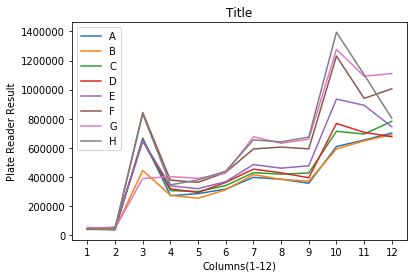

In [14]:
#plot a certain time point with each row as a line

timepoint=1
datatoplot1=totaldic[listofkeys1[timepoint]]/odresult
for i in range(8):
    pylab.plot(datatoplot1[i])
pylab.legend(nameforcol[:8])
pylab.xticks(range(0,12),range(1,13))
pylab.title('Title')
pylab.ylabel('Plate Reader Result')
pylab.xlabel('Columns(1-12)')
graph1= pylab.gcf()

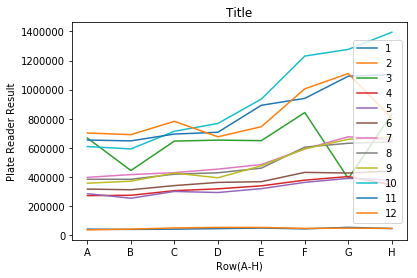

In [13]:
#plot a certain time point with each column as a line
timepoint=1
datatoplot2=totaldic[listofkeys1[timepoint]]/odresult
for j in range(12):
    pylab.plot(datatoplot2[:,j])
pylab.legend(range(1,13))
pylab.title('Title')
pylab.ylabel('Plate Reader Result')
pylab.xlabel('Row(A-H)')
pylab.xticks(range(8), nameforcol[:8])
graph2= pylab.gcf()

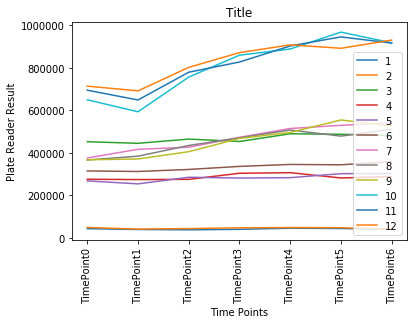

In [25]:
#plot a certain row point with different time point
rownum=1
datan=[]
for k in range(len(listofkeys1)):
    datatoplot3=totaldic[listofkeys1[k]]/odresult
    datan.append(datatoplot3[rownum])
datan=np.array(datan)
for k2 in range(len(datan[0])):
    pylab.plot(datan[:,k2])
pylab.legend(range(1,13))
pylab.xticks(range(len(listofkeys1)),listofkeys1,rotation=90)
pylab.title('Title')
pylab.ylabel('Plate Reader Result')
pylab.xlabel('Time Points')
graph3= pylab.gcf()

(7, 8)


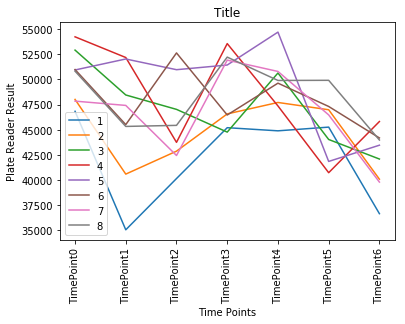

In [33]:
#plot a certain column point with different time point
colnum=1
datan2=[]
for l in range(len(listofkeys1)):
    datatoplot4=totaldic[listofkeys1[l]]/odresult
    datan2.append(datatoplot4[:,colnum])

datan2=np.array(datan2)
print(datan2.shape)
for l2 in range(len(datan2[0])):
    pylab.plot(datan2[:,l2])
pylab.legend(range(1,9))
pylab.xticks(range(len(listofkeys1)),listofkeys1,rotation=90)
pylab.title('Title')
pylab.ylabel('Plate Reader Result')
pylab.xlabel('Time Points')
graph4= pylab.gcf()